In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [2]:

data_train = pd.read_csv('/content/Ben_fulltrain.csv')
data_train.head()


Unnamed: 0                                               Text  label
0           0  কবির সিংহ একেবারে জ্ঞানহীন সিনেমা .... এখানকার...      2
1           1  @ তরুন ভার্মা আপনি কোন মেয়েকে দেখেছেন যে আমি ...      2
2           2  কিছু লোক ভাল জিনিস পছন্দ করেন না তাদের সম্পর্ক...      2
3           3              ভাই আপনি এই প্রজন্মের একজন ত্রাণকর্তা      2
4           4  আমি নারীবাদী নই ... L n আমি লাস্ট স্টোরিগুলি ঘ...      2

In [3]:
data_test = pd.read_csv('/content/trac2_iben_dev.csv')

In [4]:
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)

In [5]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [6]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0   Ek dom sothik kotha bolecho jhekane theka uthe...           0
2                                    DARUN AKDOM THIK           0
5                                     Kadam thik dada           0
12                               Supar bolla cho dada           0
15                                              Pagle           0

In [7]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [8]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [9]:
X = data_train.Text.astype(str)
Y = data_train.label
#le = LabelEncoder()
#Y = le.fit_transform(Y)
#Y = Y.reshape(-1,1)

In [10]:
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.15)

In [11]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[53, 53, 214, 169]]


In [12]:

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )


In [13]:

x_train = pad_sequences(x_train, padding='post', maxlen=150)
x_valid = pad_sequences(x_valid, padding='post', maxlen=150)
x_test = pad_sequences(x_test, padding='post', maxlen=150)

In [14]:
train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(data_test['label'].tolist())

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [16]:

max_features =50000
embedding_dim =16
sequence_length = 150

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.Accuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 150, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 150, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1229312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [17]:
epochs = 30
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/30
7/7 [==============================] - 9s 810ms/step - loss: 4.0510 - accuracy: 0.0000e+00 - val_loss: 3.0270 - val_accuracy: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 5s 716ms/step - loss: 2.7862 - accuracy: 3.6401e-05 - val_loss: 2.1258 - val_accuracy: 0.0000e+00
Epoch 3/30
7/7 [==============================] - 5s 711ms/step - loss: 1.9881 - accuracy: 0.1892 - val_loss: 1.6422 - val_accuracy: 0.5185
Epoch 4/30
7/7 [==============================] - 5s 709ms/step - loss: 1.5902 - accuracy: 0.4884 - val_loss: 1.5045 - val_accuracy: 0.5185
Epoch 5/30
7/7 [==============================] - 5s 710ms/step - loss: 1.5240 - accuracy: 0.5174 - val_loss: 1.6566 - val_accuracy: 0.5185
Epoch 6/30
7/7 [==============================] - 5s 714ms/step - loss: 1.7373 - accuracy: 0.5193 - val_loss: 2.0595 - val_accuracy: 0.5185
Epoch 7/30
7/7 [==============================] - 5s 709ms/step - loss: 2.1948 - accuracy: 0.5052 - val_loss: 2.6887 - val_accuracy: 0.5185
Epoc

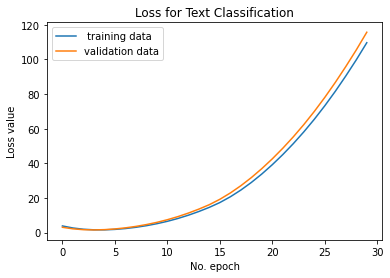

In [18]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [19]:

x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=150)


In [20]:

print("Generate predictions for all samples")
predictions = model.predict(x_test)

Generate predictions for all samples


In [21]:

data_test['pred']= predictions

In [22]:

labels = [0,1,2]
    
print(classification_report(data_test['label'].tolist(),data_test['pred'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       522
           1       0.28      0.56      0.38       218
           2       0.00      0.00      0.00       217

    accuracy                           0.54       957
   macro avg       0.34      0.43      0.37       957
weighted avg       0.47      0.54      0.49       957

